In [42]:
%matplotlib widget
import torch
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime

In [54]:
R = 1
A = 1
B = 1
nx = 200
dx = (2 * R) / (nx + 1)
T = 4.827 * A

config = {
    'domain': {
        'minExtent': -3 * R,
        'maxExtent': 3 * R,
        'dim': 2,
        'periodic': False
    },
    'particle': {
        'nx': nx,
        'dx': dx,
    },
    'compute':{
        'device': 'cuda'
    },
    'fluid':{
        'cs' : 15 * R * A
    },
    'shifting':{
        'scheme': 'deltaPlus',
        'maxIterations': 1,
        'threshold': 0.05,
        'surfaceScaling' : 1.0,
        'freeSurface': True
    },
    'gravity':{
        'active': True,
        'magnitude': B,
        'gravityMode':'potentialField'
    },
    'kernel':{
        'name': 'Wendland4'
    }
}
config = parseDefaultParameters(config)
config = parseModuleParameters(config)

# display(config)

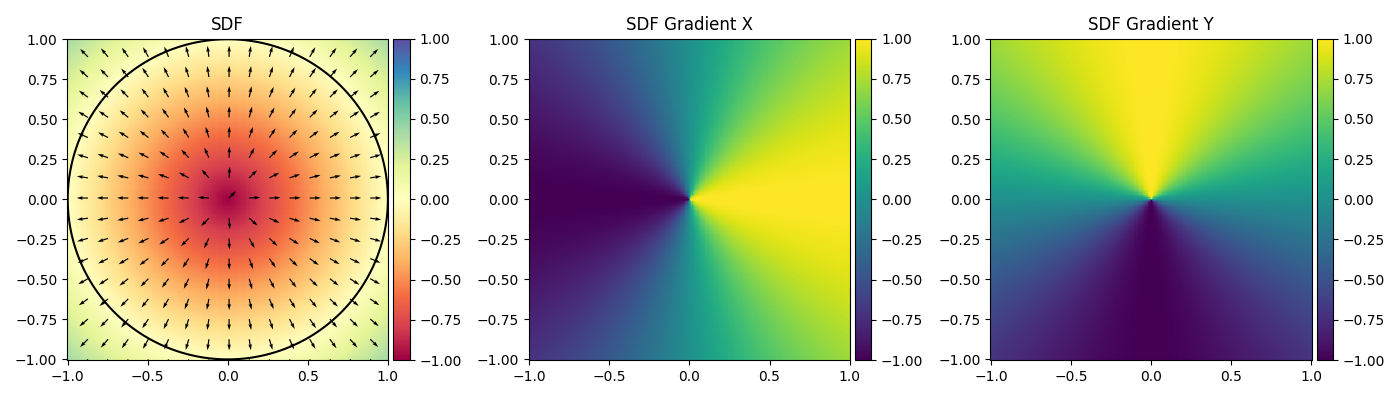

In [55]:
from diffSPH.v2.sdf import getSDF, operatorDict
from diffSPH.v2.plotting import *
ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('circle')['function'](points, R)
sdf = sphere_a
plotSDF(sdf(torch.clone(points.to('cuda')),), X.to('cuda'), Y.to('cuda'), 2, 2)

In [56]:
fluidState, mask = sampleParticles(config, sdfs = [sdf], 
    minExtent = [-R + config['particle']['dx'] / 2, -R + config['particle']['dx'] / 2], 
    maxExtent = [ R - config['particle']['dx'] / 2,  R - config['particle']['dx'] / 2])

In [57]:
# fluidState,_ = sampleParticles(config)
# boundaryState = processBoundarySDFs(fluidState, config, [sdf], 'sdf')

# display(boundaryState)

particleState = {
    'fluid': fluidState,
    # 'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}

In [114]:
from diffSPH.v2.modules.neighborhood import searchNeighbors
perennialState = copy.deepcopy(particleState)

priorState = None
config['diffusion']['velocityScheme'] = 'deltaSPH_inviscid'
config['diffusion']['nu'] = 0.01
config['diffusion']['alpha'] = 0.01

A = 1
perennialState['fluid']['velocities'][:,0] =  A * perennialState['fluid']['positions'][:,0]
perennialState['fluid']['velocities'][:,1] = -A * perennialState['fluid']['positions'][:,1]
searchNeighbors(perennialState, config)
# perennialState['fluid']['neighborhood'] = fluidNeighborSearch(perennialState, config)

In [115]:

# from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
# from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
# from diffSPH.v2.sphOps import sphOperationFluidState
# from diffSPH.v2.util import countUniqueEntries
# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
# from diffSPH.v2.math import pinv2x2, scatter_sum
# from diffSPH.v2.sphOps import sphOperation, sphOperationFluidState
# from diffSPH.v2.math import scatter_sum
# from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
# from diffSPH.v2.modules.viscosity import computeViscosity
# from diffSPH.v2.modules.pressureEOS import computeEOS
# from diffSPH.v2.modules.pressureForce import computePressureAccel
# from diffSPH.v2.modules.gravity import computeGravity


# def simulationStep(simulationState, config, diffusion = 'yes'):
#     simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
#     _, simulationState['fluidNumNeighbors'] = countUniqueEntries(simulationState['fluidNeighborhood']['indices'][0], simulationState['fluidPositions'])
    
#     simulationState['fluidL'], _, simulationState['L.EVs'] = computeNormalizationMatrices(simulationState, config)
#     simulationState['fluidGradRho^L'] = renormalizedDensityGradient(simulationState, config)
#     # simulationState['fluidGradRho'] = sphOperationFluidState(simulationState, (simulationState['fluidDensities'], simulationState['fluidDensities']), operation = 'gradient', gradientMode='difference')
    
#     simulationState['fluidDensityDiffusion'] = computeDensityDeltaTerm(simulationState, config)
#     simulationState['fluidMomentumEquation'] = computeMomentumEquation(simulationState, config)

#     simulationState['fluidVelocityDiffusion'] = computeViscosity(simulationState, config)
#     simulationState['fluidPressures'] = computeEOS(simulationState, config)

#     if config['deltaSPH']['pressureSwitch']:
#         # simulationState['fluidNormals'], simulationState['fluidLambdas'] = computeNormalsMaronne(simulationState, config)
#         simulationState['fluidFreeSurface']= detectFreeSurfaceBarecasco(simulationState, config)
#         (i,j) = simulationState['fluidNeighborhood']['indices']
#         numParticles = simulationState['numParticles']
#         simulationState['fluidSurfaceMask'] = scatter_sum(simulationState['fluidFreeSurface'][j], i, dim = 0, dim_size = numParticles)
#         simulationState['fluidPressureAccel'] = computePressureAccelSwitch(simulationState, config)
#     else:
#         simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config)

#     simulationState['fluidDivergence'] = sphOperationFluidState(simulationState, (simulationState['fluidVelocities'], simulationState['fluidVelocities']), 'divergence')

#     simulationState['fluidGravityAccel'] = computeGravity(simulationState, config) #/ simulationState['fluidMasses'].unsqueeze(-1)

#     dudt = simulationState['fluidPressureAccel'] + simulationState['fluidGravityAccel']
#     drhodt = simulationState['fluidMomentumEquation']

#     if diffusion == 'yes':
#         dudt += simulationState['fluidVelocityDiffusion']
#         drhodt += simulationState['fluidDensityDiffusion']
#     elif diffusion == 'only':
#         dudt = simulationState['fluidVelocityDiffusion']
#         drhodt = simulationState['fluidDensityDiffusion']
#     elif diffusion == 'no':
#         pass
    
#     return simulationState['fluidVelocities'].clone(), dudt, drhodt


In [116]:
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices

def callModule(state, module, config, direction = 'all', reduce = 'sum', **kwargs):
    if not config['boundary']['active']:
        return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
    if direction == 'all':
        if not config['boundary']['active']:
            return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
        else:
            ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
            # print(f' fluid -> fluid: {ftf.shape}, mean: {ftf.mean()}, min: {ftf.min()}, max: {ftf.max()}')
            btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
            # print(f' boundary -> boundary: {btb.shape}, mean: {btb.mean()}, min: {btb.min()}, max: {btb.max()}')
            btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
            # print(f' boundary -> fluid: {btf.shape}, mean: {btf.mean()}, min: {btf.min()}, max: {btf.max()}')
            ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
            # print(f' fluid -> boundary: {ftb.shape}, mean: {ftb.mean()}, min: {ftb.min()}, max: {ftb.max()}')

            if reduce == 'sum':
                return ftf + btf, btb + ftb
            elif reduce == 'min':
                return torch.min(ftf, btf), torch.min(btb, ftb)
            elif reduce == 'max':
                return torch.max(ftf, btf), torch.max(btb, ftb)
            else:
                raise ValueError(f"Invalid reduce {reduce}")
            
    if direction == 'fluid':
        return module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs), None
    if direction == 'fluidwBoundary':
        ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
        btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return ftf + btf, None
        elif reduce == 'min':
            return torch.min(ftf, btf), None
        elif reduce == 'max':
            return torch.max(ftf, btf), None
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    if direction == 'boundary':
        return None, module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
    if direction == 'boundarywFluid':
        btb = module(state['boundary'], state['boundary'], state['boundary']['neighborhood'], config, **kwargs)
        ftb = module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return None, btb + ftb
        elif reduce == 'min':
            return None, torch.min(btb, ftb)
        elif reduce == 'max':
            return None, torch.max(btb, ftb)
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    if direction == 'fluidToBoundary':
        return None, module(state['boundary'], state['fluid'], state['fluidToBoundaryNeighborhood'], config, **kwargs)
    if direction == 'boundaryToFluid':
        return module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs), None
    if direction == 'oneWay':
        ftf = module(state['fluid'], state['fluid'], state['fluid']['neighborhood'], config, **kwargs)
        btf = module(state['fluid'], state['boundary'], state['boundaryToFluidNeighborhood'], config, **kwargs)
        if reduce == 'sum':
            return ftf + btf, None
        elif reduce == 'min':
            return torch.min(ftf, btf), None
        elif reduce == 'max':
            return torch.max(ftf, btf), None
        else:
            raise ValueError(f"Invalid reduce {reduce}")
    raise ValueError(f"Invalid direction {direction}")


from diffSPH.v2.simulationSchemes.deltaPlus import callModule
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates, LiuLiuConsistent
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm, densityGradient
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
# from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch, searchNeighbors
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices
# from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles, mDBCDensity
from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation



def computePressureAccelNonConservative(stateA, stateB, neighborhood, config):
    with record_function("[SPH] - Pressure Acceleration (1/rho nabla p)"):
        (i,j) = neighborhood['indices']
        p_i = stateA['pressures'][i]
        p_j = stateB['pressures'][j]
        p_ij = p_j + p_i
        # p_ij = p_j + p_i

        masses = (stateA['masses'], stateB['masses'])
        densities = (stateA['densities'], stateB['densities'])
        i, j = neighborhood['indices']
        gradKernels = neighborhood['gradients']
        numParticles = stateA['numParticles']

        k = (masses[1][j] / (densities[0][i] * densities[1][j] )).view(-1,1) * gradKernels
        qij = p_ij
        kq = torch.einsum('n... , nd -> n...d', qij, k)

        return -scatter_sum(kq, i, dim = 0, dim_size = numParticles)

        return -sphOperationStates(stateA, stateB, p_ij, operation = 'gradient', gradientMode='summation') / stateA['densities'].view(-1,1)
        return -sphOperationStates(stateA, stateB, (stateA['pressures'], stateB['pressures']), operation = 'gradient', gradientMode='summation', neighborhood= neighborhood) / stateA['densities'].view(-1,1)
    

def checkNaNs(state):
    for key in state:
        if isinstance(state[key], torch.Tensor):
            if torch.any(torch.isnan(state[key])):
                print(f'NaNs in {key}')
                raise RuntimeError(f'NaNs in {key}')
        if not isinstance(state[key], dict):
            continue
        for subkey in state[key]:
            if not isinstance(state[key][subkey], torch.Tensor):
                continue
            if torch.any(torch.isnan(state[key][subkey])):
                print(f'NaNs in {key} - {subkey}')
                raise RuntimeError(f'NaNs in {key} - {subkey}')
def checkNaN(tensor, name):
    if torch.any(torch.isnan(tensor)):
        print(f'NaNs in {name}, number of NaNs: {torch.sum(torch.isnan(tensor))}')
        raise RuntimeError(f'NaNs in {name}, number of NaNs: {torch.sum(torch.isnan(tensor))}')

def simulationStep(state, config):
    if config['compute']['checkNaN']:
        checkNaNs(state)


    with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
        searchNeighbors(state, config)
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (2 - Ghost Particle Creation)"):
        if config['boundary']['active'] and 'boundary' in state:
            state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
        if 'regions' in  config and config['regions'] is not None:
            state['outletGhost'] = buildOutletGhostParticles(config['regions'], state, config)
        # torch.cuda.synchronize()
        
    with record_function("[SPH] - deltaSPH (3 - Density Computation)"):
        if config['simulation']['densityScheme'] == 'summation':
            if config['boundary']['active']:
                state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
            else:
                state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')
            torch.cuda.synchronize()
        # print(f'Density Min: {state["fluid"]["densities"].min()}, Max: {state["fluid"]["densities"].max()}')
        if config['boundary']['active']:
            with record_function("[SPH] - deltaSPH (3 - mDBC Density Estimate)"):
                state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)
                # state['boundary']['densities'] += torch.abs(state['boundary']['distances']) / config['particle']['support'] * 2
                # torch.cuda.synchronize()
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['densities'], 'densities')
        if config['boundary']['active']:
            if config['compute']['checkNaN']:
                checkNaN(state['boundary']['densities'], 'boundary - densities')
    if 'regions' in config and config['regions'] is not None:
        if state['outletGhost'] is not None:
            with record_function("[SPH] - deltaSPH (4 - Outlet Processing)"):
                ghostState = state['outletGhost']
                neighbors = ghostState['neighborhood']['indices'][0]
                solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['densities'])

                cond = torch.logical_and(ghostState['numNeighbors'] >= 1, ghostState['sdf_dist'] < 2.5 * config['particle']['support'])
                cond = ghostState['numNeighbors'] >= 10

                def updateQuantity(state, ghostState, quantity, solution, cond):
                    return torch.where(cond, solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:]), quantity)
                state['fluid']['densities'][ghostState['fluidIndex']] = updateQuantity(state, ghostState, state['fluid']['densities'][ghostState['fluidIndex']], solution, cond)
                state['fluid']['outletMarker'] = state['fluid']['densities'].new_zeros(state['fluid']['densities'].shape[0])
                state['fluid']['outletMarker'][ghostState['fluidIndex']] = 1

                solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,0])
                state['fluid']['velocities'][ghostState['fluidIndex'],0] = updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,0], solution, cond)

                
                solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,1])
                state['fluid']['velocities'][ghostState['fluidIndex'],1] =updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,1], solution, cond)

                if config['compute']['checkNaN']:
                    checkNaN(state['fluid']['densities'], 'densities')
                    checkNaN(state['fluid']['velocities'], 'velocities')
                

                # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (5 - Normalization Matrices)"):
        # state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
        state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluidwBoundary')
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['covarianceMatrix'], 'covarianceMatrix')
        state['fluid']['covarianceMatrix'][state['fluid']['numNeighbors'] < 4,:,:] = torch.eye(2, dtype = state['fluid']['covarianceMatrix'].dtype, device = state['fluid']['covarianceMatrix'].device)[None,:,:]


        state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])
    
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['L'], 'L')
            checkNaN(state['fluid']['L.EVs'], 'L.EVs')

        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (6 - Density Gradient)"):
        state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['gradRho^L'], 'gradRho^L')

        if config['boundary']['active']:
            state['fluid']['gradRho^L'] += callModule(state, densityGradient, config, 'boundaryToFluid')[0]


        # state['boundary']['gradRho^L'] = callModule(state, densityGradient, config, 'boundary')[1]
        # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (7 - Diffusion and Momentum)"):
        state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['densityDiffusion'], 'densityDiffusion')
        # config['diffusion']['densityScheme'] = 'deltaSPH
        # state['fluid']['densityDiffusion'] += callModule(state, computeDensityDeltaTerm, config, 'boundaryToFluid')[0]

        # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
        # torch.cuda.synchronize()
        if config['boundary']['active']:
            # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
            state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'fluid')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['velocityDiffusion'], 'velocityDiffusion')
                # checkNaN(state['boundary']['velocityDiffusion'], 'boundary - velocityDiffusion')

            state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['momentumEquation'], 'momentumEquation')
                # checkNaN(state['boundary']['momentumEquation'], 'boundary - momentumEquation')
        else:
            state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['velocityDiffusion'], 'velocityDiffusion')

            state['fluid']['momentumEquation'], _ = callModule(state, computeMomentumEquation, config, 'fluid')
            if config['compute']['checkNaN']:
                checkNaN(state['fluid']['momentumEquation'], 'momentumEquation')
        # torch.cuda.synchronize()
        state['fluid']['pressures'] = computeEOS(state['fluid'], config)
        if config['compute']['checkNaN']:
                checkNaN(state['fluid']['pressures'], 'pressures')

        if 'boundary' in state:
            state['boundary']['pressures'] = computeEOS(state['boundary'], config)
            if config['compute']['checkNaN']:
                checkNaN(state['boundary']['pressures'], 'boundary - pressures')

    with record_function("[SPH] - deltaSPH (8 - Pressure Forces)"):
        if 'boundary' in state:
            state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')
            state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccelNonConservative, config, 'fluid')
            if config['compute']['checkNaN']:
                # print(f'Pressure Min: {state["fluid"]["pressureAccel"].min()}, Max: {state["fluid"]["pressureAccel"].max()}')
                # print(f'Density Min: {state["fluid"]["densities"].min()}, Max: {state["fluid"]["densities"].max()}')
                # if 'outletMarker' in state['fluid']:
                #     print('In Mask:')
                #     print(f'Pressure Min: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 1].min()}, Max: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 1].max()}')
                #     print(f'Density Min: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 1].min()}, Max: {state["fluid"]["densities"][state["fluid"]["outletMarker"]== 1].max()}')

                #     print('Out Mask:')
                #     print(f'Pressure Min: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 0].min()}, Max: {state["fluid"]["pressureAccel"][state["fluid"]["outletMarker"] == 0].max()}')
                #     print(f'Density Min: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 0].min()}, Max: {state["fluid"]["densities"][state["fluid"]["outletMarker"] == 0].max()}')


                checkNaN(state['fluid']['pressureAccel'], 'pressureAccel')
                checkNaN(state['boundary']['pressureAccel'], 'boundary - pressureAccel')
        else:
            state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccel, config, 'fluid')
            state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccelNonConservative, config, 'fluid')
            checkNaN(state['fluid']['pressureAccel'], 'pressureAccel')
        # torch.cuda.synchronize()
    # state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')

    with record_function("[SPH] - deltaSPH (9 - External Forcing)"):
        state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)
        if config['compute']['checkNaN']:
            checkNaN(state['fluid']['gravityAccel'], 'gravityAccel')
        # torch.cuda.synchronize()

    # if config['SPS']['active']:
    #     with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
    #         state['fluid']['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)
    # torch.cuda.synchronize()

    with record_function("[SPH] - deltaSPH (10 - Integration)"):
        dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
        drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']

        # print('Momentum Term: Mean - ', state['fluid']['momentumEquation'].mean(), 'Max - ', state['fluid']['momentumEquation'].max(), 'Min - ', state['fluid']['momentumEquation'].min(), 'Sum: ', state['fluid']['momentumEquation'].sum())
        # print('Density Term: Mean - ', state['fluid']['densityDiffusion'].mean(), 'Max - ', state['fluid']['densityDiffusion'].max(), 'Min - ', state['fluid']['densityDiffusion'].min(), 'Sum: ', state['fluid']['densityDiffusion'].sum())
        

        if config['compute']['checkNaN']:
            checkNaN(dudt, 'dudt')
            checkNaN(drhodt, 'drhodt')
        

        if 'regions' in config and  config['regions'] is not None:
            if state['outletGhost'] is not None:
                dudt[ghostState['fluidIndex'],:] = 0
                drhodt[ghostState['fluidIndex']] = 0

                    
                # bi = torch.unique(state['boundaryToFluidNeighborhood']['indices'][0])
                # oi = state['outletGhost']['fluidIndex']

                # hasBoundaryNeighbors = torch.zeros(state['fluid']['numParticles'], dtype = torch.bool, device = state['fluid']['positions'].device)
                # hasBoundaryNeighbors[bi] = True

                # hasOutletNeighbors = torch.zeros(state['fluid']['numParticles'], dtype = torch.bool, device = state['fluid']['positions'].device)
                # hasOutletNeighbors[oi] = True

                # mask = torch.logical_and(hasOutletNeighbors, hasBoundaryNeighbors)
                # indices = torch.arange(state['fluid']['numParticles'], device = state['fluid']['positions'].device)[mask]

                # # print(indices)

                # projectedVelocities = state['fluid']['velocities'].clone()
                # normal = torch.Tensor([0.,1.]).to(projectedVelocities.device)
                # projectedVelocities[indices] = projectedVelocities[indices] - torch.einsum('n, d -> nd', torch.einsum('nd, d -> n', state['fluid']['velocities'][indices], normal), normal)

                # dudt_ = -(projectedVelocities - state['fluid']['velocities']) / state['timestep']
                # dudt[indices] = dudt_[indices]
                # # state['fluid']['velocities'][indices] = projectedVelocities[indices] - torch.einsum('n, d -> nd', torch.einsum('nd, d -> n', state['fluid']['velocities'][indices], normal), normal)



        if 'boundary' not in state:
            return (state['fluid']['velocities'].clone(), dudt, drhodt), (None, None, None)
        # torch.cuda.synchronize()   
        boundary_dudt = state['boundary']['pressureAccel'] #+ state['boundary']['velocityDiffusion']
        boundary_drhodt = torch.zeros_like(state['boundary']['densities'])#state['boundary']['momentumEquation'] *0

        return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)
# from diffSPH.parameter import Parameter
# def getParameters():
#     return [
#         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
#     ]


from torch.profiler import profile, record_function, ProfilerActivity


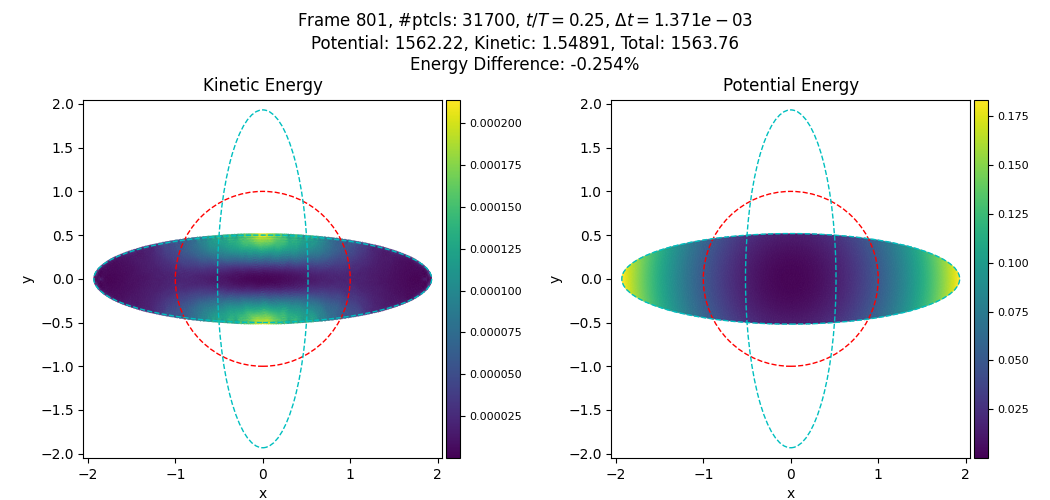

In [119]:
s = 1

fig, axis = plt.subplot_mosaic('''AB''', figsize=(10.5,5), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)
# val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
# plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
# axis['A'].set_title(r'$P/\rho\omega^2L^2$')

val = perennialState['fluid']['numNeighbors']

initialVelocity = perennialState['fluid']['velocities'].clone()
initialVelocity[:,0] =  A * particleState['fluid']['positions'][:,0]
initialVelocity[:,1] = -A * particleState['fluid']['positions'][:,1]

initialKineticEnergy = 0.5 * perennialState['fluid']['areas'] * particleState['fluid']['densities'] * torch.linalg.norm(initialVelocity, dim = -1)**2
initialPotentialEnergy = 0.5 * B**2 * perennialState['fluid']['areas'] * particleState['fluid']['densities'] * torch.linalg.norm(particleState['fluid']['positions'], dim = -1)**2

kineticEnergy = 0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2
potentialEnergy = 0.5 * B**2 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['positions'], dim = -1)**2

plotKE = visualizeParticles(fig, axis['A'], config, visualizationState, kineticEnergy , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
axis['A'].set_title(r'Kinetic Energy')


plotPE = visualizeParticles(fig, axis['B'], config, visualizationState, potentialEnergy , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
axis['B'].set_title(r'Potential Energy')


# plotPE = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluid']['pressures'] , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
# axis['B'].set_title(r'Potential Energy')

fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["fluid"]["numParticles"]}, $t/T = {perennialState["time"] / T :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$
Potential: {potentialEnergy.sum().cpu().item():.6g}, Kinetic: {kineticEnergy.sum().cpu().item():.6g}, Total: {kineticEnergy.sum().cpu().item() + potentialEnergy.sum().cpu().item():.6g}
Energy Difference: {((kineticEnergy.sum() + potentialEnergy.sum()) - (initialKineticEnergy.sum() + initialPotentialEnergy.sum())).cpu().item() / (initialKineticEnergy.sum() + initialPotentialEnergy.sum()).cpu().item() * 100:.3g}%''')

# axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
# axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)
import matplotlib.patches

initialElipse = patches.Ellipse((0,0), 2*R, 2*R, fill = False, edgecolor = 'r', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)
maxWidthElipse = patches.Ellipse((0,0), 1.931843 * 2*R, R, fill = False, edgecolor = 'c', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)
maxHeightElipse = patches.Ellipse((0,0), 2 / 1.931843 * R, 1.931843 * 2 * R, fill = False, edgecolor = 'c', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)

axis['A'].set_xlim(-2.05*R, 2.05*R)
axis['A'].set_ylim(-2.05*R, 2.05*R)
axis['A'].add_patch(initialElipse)
axis['A'].add_patch(maxWidthElipse)
axis['A'].add_patch(maxHeightElipse)
axis['B'].set_xlim(-2.05*R, 2.05*R)
axis['B'].set_ylim(-2.05*R, 2.05*R)
initialElipse = patches.Ellipse((0,0), 2*R, 2*R, fill = False, edgecolor = 'r', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)
maxWidthElipse = patches.Ellipse((0,0), 1.931843 * 2 *R, 2 / 1.931843 * R, fill = False, edgecolor = 'c', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)
maxHeightElipse = patches.Ellipse((0,0), 2 / 1.931843 * R, 1.931843 * 2 * R, fill = False, edgecolor = 'c', linewidth = 1, linestyle = '--')#.set_clip_box(axis['A'].bbox)
axis['B'].add_patch(initialElipse)
axis['B'].add_patch(maxWidthElipse)
axis['B'].add_patch(maxHeightElipse)


fig.tight_layout()


In [111]:
config['integration']

{'scheme': 'RK4'}

In [118]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
# outFolder = './output/' + timestamp + '/'
# os.makedirs(outFolder, exist_ok = True)

timeLimit = 1 * T

pbar = tqdm(total=int(timeLimit * 1000))

KEs = []
PEs = []

for i in range(4096):
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluid']['positions'] += dx

    # dxdt, dudt, drhodt = simulationStep(perennialState, config, diffusion = 'only')
    # perennialState['fluid']['velocities'] += dudt * config['timestep']['dt']
    # perennialState['fluid']['densities'] += drhodt * config['timestep']['dt']

    # perennialState, *priorState = integrate(lambda state, config: simulationStep(state, config, diffusion = 'no'), perennialState, config, previousStep= priorState)
    # perennialState, *priorState = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # Particle shifting


    # dx, _ = solveShifting(perennialState, config)
    # perennialState['fluidPositions'] += dx
    # Frame done, update state for next timestep
    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    perennialState['dt'] = config['timestep']['dt']
    config['timestep']['dt'] = computeTimestep(perennialState, config)
    time = perennialState['time']
    dt = config['timestep']['dt']

    kineticEnergy = 0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2
    potentialEnergy = 0.5 * B**2 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['positions'], dim = -1)**2

    KEs.append(kineticEnergy.sum().cpu().item())
    PEs.append(potentialEnergy.sum().cpu().item())

    pbar.n = int(time  * 1000)
    pbar.refresh()
    pbar.set_description(f"t/T = {time / T:.3g}, dt = {dt:.3e}, KE = {kineticEnergy.sum().cpu().item():.3g}, PE = {potentialEnergy.sum().cpu().item():.3g}, Difference = {((kineticEnergy.sum() + potentialEnergy.sum()) - (initialKineticEnergy.sum() + initialPotentialEnergy.sum())).cpu().item() / (initialKineticEnergy.sum() + initialPotentialEnergy.sum()).cpu().item() * 100:.3g}%")

    if time > timeLimit:
        break

    if perennialState["timestep"] % 16 == 1:
       
        fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["fluid"]["numParticles"]}, $t/T = {perennialState["time"] / T :.3g}$, $\Delta t = {perennialState["dt"]:.3e}$
        Potential: {potentialEnergy.sum().cpu().item():.6g}, Kinetic: {kineticEnergy.sum().cpu().item():.6g}, Total: {kineticEnergy.sum().cpu().item() + potentialEnergy.sum().cpu().item():.6g}
        Energy Difference: {((kineticEnergy.sum() + potentialEnergy.sum()) - (initialKineticEnergy.sum() + initialPotentialEnergy.sum())).cpu().item() / (initialKineticEnergy.sum() + initialPotentialEnergy.sum()).cpu().item() * 100:.3g}%''')


        # val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
        # val = perennialState['fluidNumNeighbors']
        # axis['A'].set_xlim(perennialState['fluidPositions'][:,0].min().cpu().item()*1.1, perennialState['fluidPositions'][:,0].max().cpu().item()*1.1)
        # axis['A'].set_ylim(perennialState['fluidPositions'][:,1].min().cpu().item()*1.1, perennialState['fluidPositions'][:,1].max().cpu().item()*1.1)


        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(plotKE, visualizationState, kineticEnergy)
        updatePlot(plotPE, visualizationState, potentialEnergy)
        fig.canvas.draw()
        fig.canvas.flush_events()
        # fig.savefig(outFolder + 'frame_{:04d}.png'.format(perennialState["timestep"]), dpi = 300)

  0%|          | 0/4827 [00:00<?, ?it/s]

Density Mean: k1 1.3400778016148251e-06, k2 2.5929486751556396, k3 2.5929019451141357, k4 5.142313003540039	 Total: 2.5856692790985107
Density Sum: k1 0.04248046875, k2 82196.4765625, k3 82194.9921875, k4 163011.328125	 Total: 81965.71875
Density Mean: k1 5.156491279602051, k2 9.029232025146484, k3 8.940686225891113, k4 12.608291625976562	 Total: 8.950770378112793
Density Sum: k1 163460.78125, k2 286226.65625, k3 283419.75, k4 399682.875	 Total: 283739.4375
Density Mean: k1 12.662158012390137, k2 16.284482955932617, k3 16.13335418701172, k4 19.59349250793457	 Total: 16.181888580322266
Density Sum: k1 401390.4375, k2 516218.125, k3 511427.375, k4 621113.75	 Total: 512965.90625
Density Mean: k1 19.615385055541992, k2 22.957788467407227, k3 22.834821701049805, k4 26.107866287231445	 Total: 22.88474464416504
Density Sum: k1 621807.75, k2 727761.9375, k3 723863.875, k4 827619.375	 Total: 725446.4375
Density Mean: k1 26.088361740112305, k2 29.22700309753418, k3 29.13894271850586, k4 32.19895

KeyboardInterrupt: 

In [14]:
import subprocess
import shlex
output = 'oscillatingDroplet'
scale = 1280

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 30 ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale={scale}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps=30,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp if output == "timestamp" else output}.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

CompletedProcess(args=['ffmpeg', '-hide_banner', '-y', '-i', './output/2024_03_07-23_45_59/output.mp4', '-i', './output/2024_03_07-23_45_59/palette.png', '-filter_complex', 'fps=30,scale=1280:-1:flags=lanczos[x];[x][1:v]paletteuse', 'oscillatingDroplet.gif'], returncode=0)

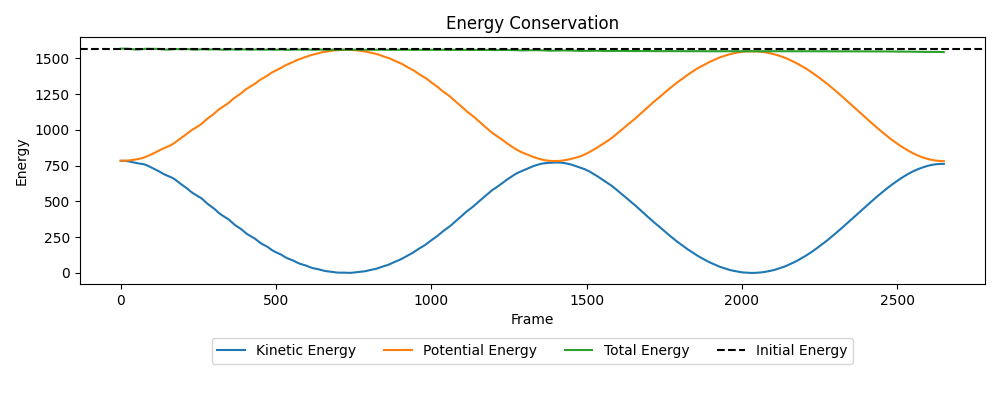

In [15]:
fig, axis = plt.subplots(1,1, figsize = (10,4), squeeze=False)

axis[0,0].plot(KEs, label = 'Kinetic Energy')
axis[0,0].plot(PEs, label = 'Potential Energy')
axis[0,0].plot(np.array(KEs) + np.array(PEs), label = 'Total Energy')
axis[0,0].axhline(KEs[0] + PEs[0], color = 'k', linestyle = '--', label = 'Initial Energy')
axis[0,0].set_xlabel('Frame')
axis[0,0].set_ylabel('Energy')
axis[0,0].set_title('Energy Conservation')

# Move the legend outside of the plot
axis[0,0].legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', ncol = 4)

fig.tight_layout()

In [ ]:
potentialEnergy = 0.5 * B**2 * (torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2)

In [56]:
r2 = torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2
v2 = torch.linalg.norm(initialVelocity, dim = -1)**2

dr = torch.linalg.norm(particleState['fluidPositions'], dim = -1) - torch.linalg.norm(perennialState['fluidPositions'], dim = -1)
dv = torch.linalg.norm(initialVelocity, dim = -1) - torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)

print(r2, v2)

print(perennialState['fluidMasses'])

print(dr, dv)
print(dr / dv)

tensor([0.3226, 0.3143, 0.3067,  ..., 0.3066, 0.3140, 0.3225], device='cuda:0') tensor([0.9982, 0.9957, 0.9933,  ..., 0.9933, 0.9957, 0.9982], device='cuda:0')
tensor([0.0990, 0.0990, 0.0990,  ..., 0.0990, 0.0990, 0.0990], device='cuda:0')
tensor([0.4311, 0.4372, 0.4429,  ..., 0.4429, 0.4375, 0.4312], device='cuda:0') tensor([0.9509, 0.9496, 0.9482,  ..., 0.9482, 0.9495, 0.9508], device='cuda:0')
tensor([0.4534, 0.4604, 0.4670,  ..., 0.4671, 0.4607, 0.4535], device='cuda:0')


In [81]:
Omega = 1
delta = 1


A = (torch.max(particleState['fluidPositions'][:,0]) - torch.min(particleState['fluidPositions'][:,0]) + config['particle']['dx']) / 2
B = (torch.max(particleState['fluidPositions'][:,1]) - torch.min(particleState['fluidPositions'][:,1]) + config['particle']['dx']) / 2

A_current = (torch.max(perennialState['fluidPositions'][:,0]) - torch.min(perennialState['fluidPositions'][:,0])) / 2
B_current = (torch.max(perennialState['fluidPositions'][:,1]) - torch.min(perennialState['fluidPositions'][:,1])) / 2

print(A, B)
print(A_current, B_current)

tensor(0.9950, device='cuda:0') tensor(0.9950, device='cuda:0')
tensor(1.8919, device='cuda:0') tensor(0.5162, device='cuda:0')


In [87]:
E_k = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(initialVelocity, dim = -1)**2
E_p = 0.5 * B**2 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(particleState['fluidPositions'], dim = -1)**2
print(E_k.sum().cpu().item())
print(E_p.sum().cpu().item())

784.545654296875
776.7586059570312


In [88]:
E_k = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2
E_p = 0.5 * B**2 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2
print(E_k.sum().cpu().item())
print(E_p.sum().cpu().item())

1.4952871799468994
1527.4677734375


In [83]:
np.pi * A * B

tensor(3.1104, device='cuda:0')

In [84]:
torch.sum(perennialState['fluidAreas'])

tensor(3.1385, device='cuda:0')

In [85]:
E_k = np.pi / 8 * config['fluid']['rho0'] * delta**2 * A * B * (A**2 + B**2)
E_p = np.pi / 8 * config['fluid']['rho0'] * Omega**2 * A * B * (A**2 + B**2)

print(E_k, E_p)

tensor(769.8846, device='cuda:0') tensor(769.8846, device='cuda:0')


In [69]:
E_k = np.pi / 8 * config['fluid']['rho0'] * delta**2 * A_current * B_current * (A_current**2 + B_current**2)
E_p = np.pi / 8 * config['fluid']['rho0'] * Omega**2 * A_current * B_current * (A_current**2 + B_current**2)

print(E_k, E_p)

tensor(23598.2480, device='cuda:0') tensor(23598.2480, device='cuda:0')


In [43]:
initialVelocity = perennialState['fluidVelocities'].clone()
initialVelocity[:,0] =  A * particleState['fluidPositions'][:,0]
initialVelocity[:,1] = -A * particleState['fluidPositions'][:,1]

initialKineticEnergy = 0.5 * particleState['fluidMasses'] * (torch.linalg.norm(initialVelocity, dim = -1)**2)
initialPotentialEnergy = particleState['fluidMasses'] * B * (torch.linalg.norm(particleState['fluidPositions'], dim = -1))


kineticEnergy = 0.5 * perennialState['fluidMasses'] * (torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2)
potentialEnergy = perennialState['fluidMasses'] * B * (torch.linalg.norm(perennialState['fluidPositions'], dim = -1))

totalInitialEnergy = initialKineticEnergy.sum() + initialPotentialEnergy.sum()
totalEnergy = kineticEnergy.sum() + potentialEnergy.sum()

print(f'Initial Energy: {totalInitialEnergy:.6g} (KE: {initialKineticEnergy.sum():.6g}, PE: {initialPotentialEnergy.sum():.6g})')
print(f'Final Energy: {totalEnergy:.6g} (KE: {kineticEnergy.sum():.6g}, PE: {potentialEnergy.sum():.6g})')
print(f'Energy difference: {totalEnergy - totalInitialEnergy:.3g} ({(totalEnergy - totalInitialEnergy) / totalInitialEnergy * 100:.3g}%)')

Initial Energy: 774.496 (KE: 154.839, PE: 619.657)
Final Energy: 774.496 (KE: 154.839, PE: 619.657)
Energy difference: 0 (0%)


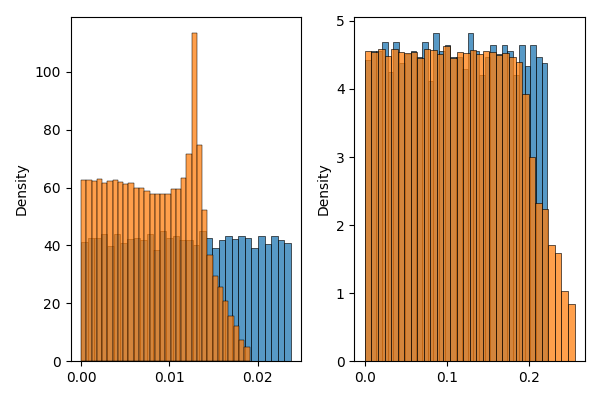

In [30]:
import seaborn as sns


fig, axis = plt.subplots(1,2, figsize = (6,4), squeeze=False)

sns.histplot(initialPotentialEnergy.cpu().numpy(), ax = axis[0,1], kde = False, stat = 'density', bins = nx//4)
sns.histplot(potentialEnergy.cpu().numpy(), ax = axis[0,1], kde = False, stat = 'density', bins = nx//4)


sns.histplot(initialKineticEnergy.cpu().numpy(), ax = axis[0,0], kde = False, stat = 'density', bins = nx//4)
sns.histplot(kineticEnergy.cpu().numpy(), ax = axis[0,0], kde = False, stat = 'density', bins = nx//4)



fig.tight_layout()

<img src = "./squarePatch.gif" width = 500/>